# A/B Testing

A/B testing is one of the most commonly employed experimental framework. It is a powerful method for comparing two versions of a variable to determine which one performs better in terms of a given metric. This technique is widely used in various fields, including marketing, product development, and website optimization, to make data-driven decisions. In this tutorial, we'll explore the basics of A/B testing, illustrate a simple example, and delve into more advanced topics, such as network effects and complex statistical considerations.

## A simple example

Consider a scenario where we want to compare the effectiveness of two different marketing campaigns aimed at encouraging customers to use more energy during off-peak hours. We'll define two groups:

- **Group A (control group)**: receives the standard marketing message.
- **Group B (treatment group)**: receives a new, enhanced marketing message.

The goal is to determine which marketing message results in higher usage of energy during off-peak hours.

**Step-by-step procedure:**

1. **Random assignment**: randomly assign customers to either Group A or Group B to ensure that each group is representative of the overall population.

2. **Implementation**: send the standard marketing message to Group A, and the enhanced marketing message to Group B.

3. **Measurement**: after a predetermined period, measure the amount of energy used by customers in both groups during off-peak hours.

4. **Analysis**: compare the average energy usage between the two groups using statistical tests, such as a **t-test**, to determine if the difference is statistically significant.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

# Simulate data
np.random.seed(42)
group_a = np.random.normal(loc=50, scale=10, size=100)  # Control group
group_b = np.random.normal(loc=55, scale=10, size=100)  # Treatment group

# Perform t-test
t_stat, p_value = stats.ttest_ind(group_b, group_a)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("The enhanced marketing message significantly increases energy usage during off-peak hours.")
else:
    print("There is no significant difference between the two marketing messages.")

T-statistic: 4.755
P-value: 0.000
The enhanced marketing message significantly increases energy usage during off-peak hours.


## Statistical considerations 

A/B testing involves several statistical concepts that needs to be taken into account to ensure valid and reliable results. These includes:

1. **Power analysis**: to determine the sample size needed to detect a significant effect.
2. **Multiple testing**: to adjust for the increased likelihood of Type I errors when conducting multiple comparisons (e.g., using Bonferroni correction).
3. **Heterogeneous treatment effects**: to explore how treatment effects vary across different subgroups.
4. **Network effects**: to eestimate treatment effects in networks where there is interference between users or consumers.


### Power analysis

Here we demonstrate how to determine the minimum number of participants needed in each group of an A/B test to ensure reliable results. This process, called power analysis, helps us calculate the sample size required to detect a meaningful difference between two groups with a high probability. Power analysis is a technique used to figure out the smallest sample size that can reliably detect an effect in an experiment. It balances the need to find real differences with the desire to avoid wasting resources on excessively large samples. Essentially, it helps ensure that our A/B test is both effective and efficient.

**Key parameters:**
- **Effect size**: this measures the expected difference between the groups. It is a standardized value that reflects how large an effect we expect the treatment to have. A common way to select the effect size is to use previous research or pilot studies to estimate the likely impact. In our example, we chose an effect size of 0.5, indicating a moderate difference that we want to detect. The effect size is a measure of the magnitude of the difference between two groups. It is not just the raw difference between the means of the two groups, but rather a standardised measure that accounts for the variability within the data. This allows for a more meaningful comparison across different contexts and studies.
- **Significance level (alpha)**: this is the threshold for determining statistical significance, often set at 0.05. It represents the probability of rejecting the null hypothesis (concluding there is an effect) when it is actually true (a false positive). We selected an alpha of 0.05, which is standard in many fields, meaning we are willing to accept a 5% chance of a false positive.
- **Power**: this represents the probability of correctly rejecting the null hypothesis when it is false, i.e., detecting a true effect. A common target for power is 0.8, or 80%, meaning we want an 80% chance of detecting the effect if it truly exists. This balance ensures that we have a high likelihood of finding true effects without requiring excessively large sample sizes.

In [2]:
from statsmodels.stats.power import TTestIndPower

# Parameters
effect_size = 0.5
alpha = 0.05
power = 0.8

# Calculate required sample size
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
print(f"Required sample size per group: {int(sample_size)}")

Required sample size per group: 63


After running the power analysis with these parameters, the output tells us the required sample size per group. For instance, if the result is 63, it means we need at least 63 participants in both the treatment and control groups. This ensures that our A/B test has enough power to detect a moderate effect with an 80% chance, while keeping the probability of a false positive at 5%. This helps in making sure our experiment is well-designed and our conclusions are reliable.

### Multiple testing

When conducting multiple tests, the probability of making at least one type I error (false positive) increases. To address this, we use the Bonferroni correction, which adjusts the significance level to control the family-wise error rate (FWER). The adjusted significance level is given by:

\begin{equation}\alpha_{\text{adj}} = \frac{\alpha}{m}\end{equation}

where $\alpha$ is the original significance level, and $m$ is the number of tests.

Let's consider an example where a utility company is testing five different marketing campaigns to see if they significantly increase the adoption of a new energy-saving device.

**Scenario**:
- The company runs five separate A/B tests, one for each marketing campaign.
- The null hypothesis for each test is that the campaign has no effect on adoption rates.
- The significance level for the tests is initially set at 0.05.

**Step-by-step procedure:**

1. **Set parameters**: original significance level (\(\alpha\)) and number of tests.

2. **Simulate p-values**: generate p-values from the five tests. In a realistic scenario, these p-values would come from actual data analysis.

3. **Apply Bonferroni correction**: adjust the significance level using the Bonferroni method, and determine which hypotheses to reject based on the corrected p-values.

In [3]:
from statsmodels.stats.multitest import multipletests

# Parameters
alpha = 0.05  # Original significance level
num_tests = 5  # Number of tests

# Adjusted significance level using Bonferroni correction
alpha_adj = alpha / num_tests
print(f"Adjusted significance level: {alpha_adj}")

# Simulate p-values from 5 tests
# Realistically, these p-values would be the result of statistical tests on actual data
np.random.seed(42)
p_values = np.array([0.02, 0.04, 0.20, 0.01, 0.03])  # Simulated p-values for illustration
print(f"Original p-values: {p_values}")

# Apply Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')
print(f"Corrected p-values: {pvals_corrected}")
print(f"Reject null hypothesis: {reject}")

# Interpretation of results
for i, (pval, corr_pval, rej) in enumerate(zip(p_values, pvals_corrected, reject)):
    print(f"Test {i + 1}: Original p-value = {pval}, Corrected p-value = {corr_pval}, Reject null hypothesis = {rej}")

Adjusted significance level: 0.01
Original p-values: [0.02 0.04 0.2  0.01 0.03]
Corrected p-values: [0.1  0.2  1.   0.05 0.15]
Reject null hypothesis: [False False False  True False]
Test 1: Original p-value = 0.02, Corrected p-value = 0.1, Reject null hypothesis = False
Test 2: Original p-value = 0.04, Corrected p-value = 0.2, Reject null hypothesis = False
Test 3: Original p-value = 0.2, Corrected p-value = 1.0, Reject null hypothesis = False
Test 4: Original p-value = 0.01, Corrected p-value = 0.05, Reject null hypothesis = True
Test 5: Original p-value = 0.03, Corrected p-value = 0.15, Reject null hypothesis = False


This correction ensures that we control the family-wise error rate, reducing the risk of false positives when conducting multiple tests. Here we used fictional p-values: `[0.02, 0.04, 0.20, 0.01, 0.03]`. In practice, these would be obtained from statistical tests on actual experimental data.

### Heterogeneous treatment effects

Heterogeneous treatment effects occur when the effect of a treatment varies across different subgroups of the population. Identifying these differences is crucial for understanding how different groups respond to the treatment and for making targeted decisions.

Suppose an electricity company is testing a new marketing campaign to encourage customers to switch to a green energy plan. The company wants to understand if the campaign's effectiveness varies by customer age. Let's simulate this case with a simple example, where:
- We generate data for 1000 customers with ages between 18 and 70.
- The `treatment` variable indicates whether the customer received the marketing campaign (1) or not (0).
- The `response` variable represents whether the customer switched to the green energy plan, influenced by their age, the treatment, and the interaction between age and treatment.

                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     3446.
Date:                Tue, 09 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:42:52   Log-Likelihood:                -1409.1
No. Observations:                1000   AIC:                             2826.
Df Residuals:                     996   BIC:                             2846.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.2533      0.135     38.770

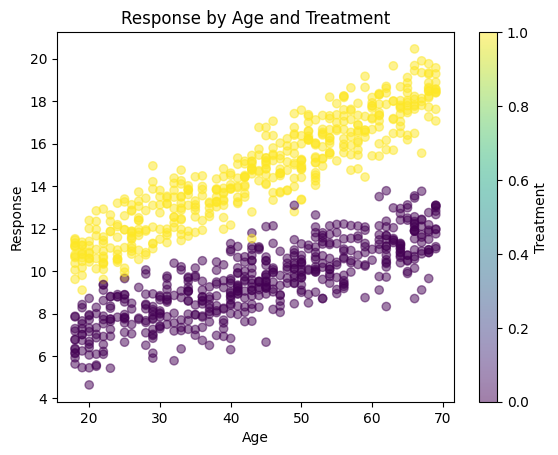

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Simulate data
np.random.seed(42)
n = 1000
age = np.random.randint(18, 70, size=n)
treatment = np.random.choice([0, 1], size=n)
age_treatment = age * treatment
response = 5 + 3 * treatment + 0.1 * age + 0.05 * age_treatment + np.random.normal(size=n)

# Create DataFrame
data = pd.DataFrame({'age': age, 'treatment': treatment, 'response': response, 'age_treatment': age_treatment})

# Fit the model
X = sm.add_constant(data[['treatment', 'age', 'age_treatment']])
model = sm.OLS(data['response'], X).fit()
print(model.summary())

# Plot interaction
plt.scatter(data['age'], data['response'], c=data['treatment'], cmap='viridis', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Response')
plt.title('Response by Age and Treatment')
plt.colorbar(label='Treatment')
plt.show()

In the results:
- The coefficient for `treatment` indicates the average effect of the marketing campaign.
- The coefficient for `age` shows the effect of age on the response.
- The coefficient for `age_treatment` reveals how the treatment effect changes with age. A significant coefficient suggests that the treatment effect varies across different age groups.

This example demonstrates how to estimate heterogeneous treatment effects in an A/B testing context. By including interaction terms in the regression model, we can identify how the treatment effect varies across different subgroups, providing valuable insights for tailoring strategies to specific segments. This approach helps maximize the effectiveness of interventions by understanding and leveraging the heterogeneity in treatment effects.

### Network effects

Traditional A/B testing methods, relying on the stable unit treatment value assumption (SUTVA), assume that each individual's response to a treatment is independent of others. However, in many real-world scenarios, especially in social networks and interconnected systems, this assumption does not hold. Users' behaviors and outcomes can be influenced by their peers, leading to network effects. Network A/B testing is an advanced technique that takes into account the influence of social connections and interactions when evaluating the effectiveness of treatments or interventions {cite}`gui2015network`. 

**Relevance of network A/B testing:**

1. **Capturing spillover effects**: in social networks, the effect of a treatment on one individual can spill over to their connected peers. For instance, in marketing campaigns, a customer's decision to adopt a new product might influence their friends to do the same.

2. **Accurate estimation of treatment effects**: by considering network effects, we can obtain more accurate estimates of the Average Treatment Effect (ATE). Ignoring these effects can lead to biased results and incorrect conclusions.

3. **Optimizing interventions**: understanding how treatments propagate through networks can help in designing more effective interventions. For example, targeting influential nodes in a network can amplify the overall impact of a campaign.


In network A/B testing, we need to account for two main factors:
- **Direct treatment effect**: The impact of the treatment on the individual who receives it.
- **Indirect treatment effect**: The impact of the treatment on individuals connected to those who receive it.

To estimate these effects, we use a model that includes both the treatment status of the individual and the treatment status of their neighbors. 

Consider a scenario where an electricity company wants to test a new marketing campaign to encourage customers to switch to a green energy plan. The company knows that customers are likely to influence each other's decisions through social interactions. Therefore, they want to account for these network effects in their A/B testing. We will simulate a network of customers, randomly assign them to treatment or control groups, and then estimate the treatment effects considering the influence of their connected peers.

**Step-by-step procedure:**

**Generating the network:** we use an Erdős-Rényi model to create a random network. In this model, each pair of nodes (customers) has a fixed probability of being connected.
  
**Simulating treatment assignment:** we randomly assign each node (customer) to either the treatment group (Z=1) or the control group (Z=0) with equal probability. This represents whether a customer receives the new marketing campaign or not.

**Simulating the response variable:** The response variable $Y$ represents the outcome we are interested in measuring, such as whether a customer switched to the green energy plan. The outcome for each customer is influenced by their own treatment status $Z$ and the treatment statuses of their connected neighbors, which we account for using the adjacency matrix $A$.

The formula used for simulating the response is:
\begin{equation}
    Y = \beta_0 + \beta_1 Z + \beta_2 (A \cdot Z) + \epsilon
\end{equation}

where:
- $\beta_0$ is the intercept.
- $\beta_1$ is the direct effect of the treatment.
- $\beta_2$ captures the network effects (i.e., how the treatment status of neighbors influences the outcome).
- $\epsilon$ is random noise.

In [5]:
import networkx as nx

# Generate a random graph
n_samples = 200
G = nx.erdos_renyi_graph(n=n_samples, p=0.05, seed=42)
A = nx.to_numpy_array(G)

# Simulate data
np.random.seed(42)
Z = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])  # Random assignment to treatment or control
Y = 2 + 1.5 * Z + 0.8 * np.dot(A, Z) + np.random.normal(size=n_samples)  # Network effects

The response $Y$ is simulated by combining the direct effect of the treatment ($Z$) and the indirect network effect ($A \cdot Z$). The term $\beta_2 (A \cdot Z)$ captures the influence of the treatment status of neighboring nodes on the outcome.

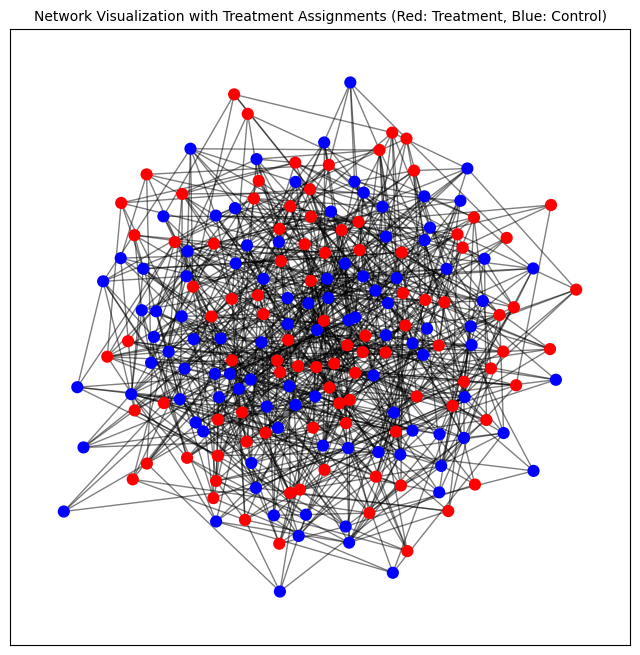

In [6]:
# Plotting the network
plt.figure(figsize=(8, 8), dpi=100)
pos = nx.spring_layout(G, seed=42)
node_color = ['r' if z == 1 else 'b' for z in Z]
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=60, alpha=1)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Network Visualization with Treatment Assignments (Red: Treatment, Blue: Control)", fontsize=10)
plt.show()

We now prepare the aata for fitting a linear regression model. In particular, we create the feature matrix $X$, which includes:
  - The treatment status $Z$ of each customer.
  - The sum of the treatment statuses of their neighbors, calculated as $A \cdot Z$.

Then, we can fit a linear regression model to estimate the coefficients $\beta_1$ and $\beta_2$, which correspond to the direct treatment effect and the network effect, respectively.

In [7]:
# Prepare the data for regression
X = np.column_stack([Z, np.dot(A, Z)])
X = sm.add_constant(X)  # Add intercept

# Fit the model using statsmodels
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     290.0
Date:                Tue, 09 Jul 2024   Prob (F-statistic):           1.98e-59
Time:                        13:42:53   Log-Likelihood:                -276.44
No. Observations:                 200   AIC:                             558.9
Df Residuals:                     197   BIC:                             568.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1994      0.191     11.502      0.0

The model summary provides the estimates for $\beta_1$ (direct treatment effect) and $\beta_2$ (network effect).
The estimated Average Treatment Effect (ATE) considering network effects is extracted from the coefficient $\beta_1$.

In [8]:
# Calculate ATE considering network effects
ATE = model.params[1]  # Coefficient for treatment
print(f"ATE considering network effects: {ATE:.3f}")

ATE considering network effects: 1.548


By simulating the response variable to include both direct and network effects, and then using regression analysis to estimate these effects, we can accurately measure the influence of treatments in interconnected systems. This approach helps account for the spillover effects that are common in social networks and other interconnected environments.